Stanislas Deneuville - Emmanuel Ferrandi - Pol Grisart - Marine Médard
# Project of data science :  Face recognition in a video and counting
16/11/2018

## Part II : Train&Use

In [79]:
import random
import keras
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

__split__ : split the set into two well mixed set 


In : 
* data : list of all the images 

Out : 
* train_set : list of the images in the training set representing 66% of data
* test_set : list of the images in the test set representing the other 34% of data

In [80]:
TRAIN_TEST_RATIO = 0.66
def split(data:list, train_test_ratio:int=TRAIN_TEST_RATIO, random_split=True) :
    if random_split:
        # Shuffle
        random.shuffle(data)
    
    # Split data
    cut_index = round(len(data) * train_test_ratio) 
    train_set = data[:cut_index]
    test_set = data[cut_index:]
    return(train_set, test_set)

In [81]:
MAX_CATEGORY = 10

def equalize(subsets):
    print("Equalizing subset")
    for nb_face,subset in enumerate(subsets):
        print("{} faces set contains {} images".format(nb_face, len(subset)))
    minimum = max(100,min([len(subset) for subset in subsets]))
    cutted_subsets = [subset[:minimum] for subset in subsets]
    return cutted_subsets

def load_and_split():
    subsets = [[] for k in range(MAX_CATEGORY+1)]
    for nb_face in range(MAX_CATEGORY+1):
        folder_path = os.path.join("train_set", str(nb_face))
        if (os.path.isdir(folder_path)) :

            # Y value of these alements
            categorical_y = np.zeros((1, MAX_CATEGORY+1))
            categorical_y[0, nb_face] = 1

            folder_path = os.path.join("train_set", str(nb_face))
            for filename in os.listdir(folder_path):
                # Filter non image files
                if ".jpeg" in filename or ".png" in filename or ".jpg" in filename:
                    x = plt.imread(os.path.join(folder_path, filename)).reshape((1, 50,50))
                    y = categorical_y
                    xy = (x,y)
                    subsets[nb_face].append(xy)
    
    # Equalize to have the same number of each Y value
    equalized_subsets = equalize(subsets)
    
    # Split data respecting equalization
    train_set, test_set = [], []
    for subset in equalized_subsets:
        add_train_set, add_test_set = split(subset)
        train_set = train_set + add_train_set
        test_set = test_set + add_test_set
    
    # Shuffle
    random.shuffle(train_set)
    random.shuffle(test_set)
    
    print("Train size = {}, test size = {}".format(len(train_set), len(test_set)))
    
    return train_set, test_set
        

__train_neuural_network__ : function that creates a neural network and trains it with the train_set 

In [82]:
class AccuracyPlotMemory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.plot_y = []

    def on_epoch_end(self, batch, logs={}):
        self.plot_y.append(logs.get('acc'))
        
    def plot(self):
        plt.plot([k+1 for k in range(len(self.plot_y))], self.plot_y)
        
        plt.ylabel('Accuracy')
        plt.xlabel('Iteration')
        plt.show()
        
plot_callback = AccuracyPlotMemory()

In [83]:
def generate_model():
    # Simple model
    model = keras.models.Sequential()
    
    # Add neurone layers
    #model.add(keras.layers.Dense(units=500, activation='relu', input_dim=50*50))
    #model.add(keras.layers.Dense(units=100, activation='relu'))
    #model.add(keras.layers.Dense(units=40, activation='relu'))
    #model.add(keras.layers.Dense(units=15, activation='relu'))
    
    # Convolutionnal model
    model.add(keras.layers.Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=(50,50, 1)))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(keras.layers.Conv2D(64, (5, 5), activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    # End with a classic model
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1000, activation='relu'))
    model.add(keras.layers.Dense(MAX_CATEGORY+1, activation='softmax'))
    
    # Learning process
    model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
    return model 

def train_neural_network(train_set, test_set=None):
    print("Generating model")
    model = generate_model()
    
    x_train = np.concatenate([x for x,y in train_set]).reshape(len(train_set), 50, 50, 1)
    y_train = np.concatenate([y for x,y in train_set])
    print("X train size = {}, y train  size = {}".format(x_train.shape, y_train.shape))
    
    xy_test = None
    if test_set is not None:
        x_test = np.concatenate([x for x,y in test_set]).reshape(len(test_set), 50, 50, 1)
        y_test = np.concatenate([y for x,y in test_set])
        xy_test = x_test, y_test
    
    print("Start training")
    model.fit(x_train, y_train, epochs=30, batch_size=32, callbacks=[plot_callback], validation_data=xy_test)
    
    return model

__evaluate_performance__ : function that applys the neural network on the images in the test_set and compare with the real number of faces in these images 

In [84]:
def evaluate_performance(model, test_set):
    
    x_test = np.concatenate([x for x,y in test_set]).reshape(len(test_set), 50, 50, 1)
    y_test = np.concatenate([y for x,y in test_set])
    plot_callback.plot()
    
    loss_and_metrics = model.evaluate(x_test, y_test, batch_size=128)
    

In [85]:
def save_model(model) :
    # serialize model to JSON
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model to disk")
 



Split
Train size = 283, test size = 144
Train
Generating model
X train size = (283, 50, 50, 1), y train  size = (283, 15)
Start training
Epoch 1/30
283/283 [==============================] - 3s 9ms/step - loss: 12.0349 - acc: 0.2191
Epoch 2/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0461 - acc: 0.2438
Epoch 3/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0460 - acc: 0.2438
Epoch 4/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0460 - acc: 0.2438
Epoch 5/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0460 - acc: 0.2438
Epoch 6/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0460 - acc: 0.2438
Epoch 7/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0460 - acc: 0.2438
Epoch 8/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0460 - acc: 0.2438
Epoch 9/30
283/283 [==============================] - 2s 7ms/step - loss: 12.0459 - acc: 0.2438

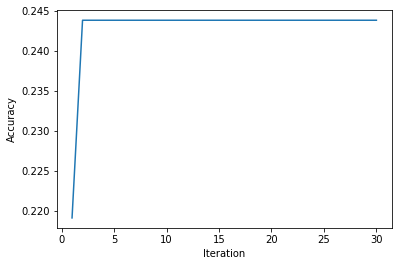

144/144 [==============================] - 0s 2ms/step


In [86]:
print("Split")
train_set, test_set = load_and_split()

print("Train")
model = train_neural_network(train_set)

print("Save")
save_model(model)

print("Evaluate")
evaluate_performance(model, test_set)

In [87]:
def manual_evaluation(model, test_et):
    x_test = np.concatenate([x for x,y in test_set]).reshape(len(test_set), 50, 50, 1)
    y_test = np.concatenate([y for x,y in test_set])
    outs = model.predict(x_test)
    
    result = [[] for k in range(MAX_CATEGORY + 1)]
    
    square_error = 0
    perfect_accuracy = 0
    count = 0
    
    for y_out, y_expected in zip(outs, y_test):
        #print(">>",y_out,"/expects/",y_expected)
        clean_expected_out = 0
        while not y_expected[clean_expected_out] == 1:
            clean_expected_out += 1
        clean_out = y_out.argmax()
        result[clean_expected_out].append(clean_out)
        
        square_error += abs(clean_expected_out-clean_out)**2
        if clean_out == clean_expected_out:
            perfect_accuracy += 1
        count += 1
        
    #print("==================")
    for k,line in enumerate(result):
        print(k,line)
    
    print("Mean square error {}".format(square_error/count))
    print("perfect match rate {}%".format(round(perfect_accuracy/count*100), 2))
    return square_error/count, perfect_accuracy/count
mean_square_error, perfect_accuracy = manual_evaluation(model, test_set)

0 [3]
1 [3, 3, 3, 3, 2, 3, 3, 3, 3]
2 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
4 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
5 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
6 [3, 3, 3, 3, 3, 3, 3, 3]
7 [3, 3, 3, 3, 3]
8 [3, 3, 3, 3]
9 [3]
10 [3]
11 [3, 3]
12 [3]
13 []
14 []


In [ ]:
#save model

# JSON
json_model = model.to_json()
with open("model_CNN_{}.json".format(round(perfect_accuracy*100)), "w") as f:
    f.write(json_model)
# Weights
model.save_weights("weight_CNN_{}.h5".format(round(perfect_accuracy*100)))
print("Model saved")